O objetivo deste projeto é prever a **quantidade de consumo mensal** com base em variáveis 
disponíveis no dataset `DasaMatHosp.xlsx`.

A variável alvo é: **quantidade_consumo_mensal**.

Esse tipo de previsão é útil para **gestão de recursos hospitalares**, pois permite antecipar 
necessidades de consumo e otimizar logística de suprimentos.



In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Carregar os dados
df = pd.read_excel("DasaMatHosp.xlsx")

# Visualizar primeiras linhas
df.head()




,Material,DataHora,Estoque,Custo_Unitario,Custo_Total
0,Seringas,2024-05-17 15:00:00,66.0,0.45,29.70
1,Máscaras N95,2024-05-27 09:00:00,320.0,5.15,1648.00
2,Algodão,2024-01-01 00:00:00,351.0,0.25,87.75
3,Seringas,2024-04-16 06:00:00,565.0,0.44,248.60
4,Luvas Cirúrgicas,2024-08-22 18:00:00,171.0,0.89,152.19


Antes de aplicar regressão linear, precisamos verificar alguns pressupostos:

- **Linearidade**: a relação entre variáveis independentes e a variável alvo deve ser aproximadamente linear.
- **Homoscedasticidade**: os resíduos devem ter variância constante.
- **Normalidade dos resíduos**: os erros devem seguir distribuição aproximadamente normal.
- **Ausência de multicolinearidade**: as variáveis independentes não podem ser altamente correlacionadas entre si.

Essas verificações serão feitas após o ajuste dos modelos.


Vamos começar com um modelo simples, relacionando apenas **uma variável independente** 
com a quantidade de consumo mensal.  

Para este exemplo, utilizaremos a variável **tempo_fidelidade** (ou outra que exista no dataset).


In [19]:
# Copiar apenas linhas sem NaN nas colunas essenciais
df_modelo = df.dropna(subset=['Estoque', 'Custo_Unitario', 'Custo_Total', 'DataHora']).copy()

# Garantir que DataHora seja datetime
df_modelo['DataHora'] = pd.to_datetime(df_modelo['DataHora'], errors='coerce')

# Extrair atributos de data
df_modelo['Ano'] = df_modelo['DataHora'].dt.year
df_modelo['Mes'] = df_modelo['DataHora'].dt.month
df_modelo['DiaSemana'] = df_modelo['DataHora'].dt.dayofweek

# Transformar variável categórica "Material" em dummies (one-hot encoding)
df_modelo = pd.get_dummies(df_modelo, columns=['Material'], drop_first=True)

# Definir variáveis explicativas (X) e alvo (y)
X_multi = df_modelo.drop(columns=['Estoque', 'DataHora'])
y = df_modelo['Estoque']

# Criar e treinar modelo de regressão linear múltipla
modelo_multi = LinearRegression()
modelo_multi.fit(X_multi, y)

# Avaliar o modelo
y_pred_multi = modelo_multi.predict(X_multi)
r2_multi = r2_score(y, y_pred_multi)
rmse_multi = np.sqrt(mean_squared_error(y, y_pred_multi))

print("Coeficientes:", modelo_multi.coef_)
print("Intercepto:", modelo_multi.intercept_)
print("R² do modelo múltiplo:", r2_multi)
print("RMSE do modelo múltiplo:", rmse_multi)


Coeficientes: [-1.14887583e+02  3.78037005e-01  7.10542736e-14  1.61951941e-02
 -8.77272060e-03  1.54309469e+01  9.76589861e+01 -4.24952688e+00
 -1.98806838e+00 -1.77295366e-01  8.44636953e+01 -5.20298051e+00
 -1.50972088e+00  3.78337089e+00]
Intercepto: 305.50178238892624
R² do modelo múltiplo: 0.6359378583940537
RMSE do modelo múltiplo: 94.30025588568377


- **Coeficiente (inclinação):** representa a variação média no consumo mensal para cada unidade 
adicional de tempo de fidelidade.
- **Intercepto:** é o valor esperado do consumo mensal quando o tempo de fidelidade é zero.


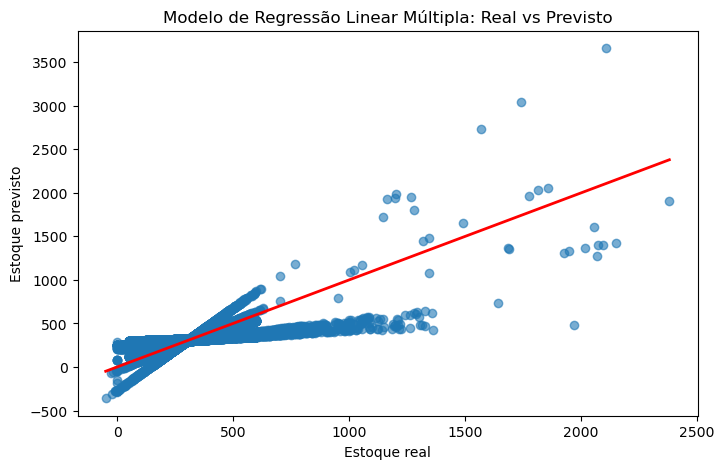

In [24]:
# Visualização: comparação entre valores reais e previstos
plt.figure(figsize=(8,5))
plt.scatter(y, y_pred_multi, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r", linewidth=2)
plt.xlabel("Estoque real")
plt.ylabel("Estoque previsto")
plt.title("Modelo de Regressão Linear Múltipla: Real vs Previsto")
plt.show()


Agora expandiremos o modelo para múltiplas variáveis independentes.  
Selecionaremos pelo menos **três variáveis relevantes** do dataset.


In [25]:
# Copiar apenas linhas sem NaN
df_modelo = df.dropna(subset=['Estoque', 'Custo_Unitario', 'Custo_Total'])

# Extrair atributos de data
df_modelo['Ano'] = df_modelo['DataHora'].dt.year
df_modelo['Mes'] = df_modelo['DataHora'].dt.month
df_modelo['DiaSemana'] = df_modelo['DataHora'].dt.dayofweek

# Transformar variável categórica "Material" em dummies
df_modelo = pd.get_dummies(df_modelo, columns=['Material'], drop_first=True)

# Definir X e y
X_multi = df_modelo.drop(columns=['Estoque', 'DataHora'])
y = df_modelo['Estoque']

# Criar modelo de regressão linear múltipla
modelo_multi = LinearRegression()
modelo_multi.fit(X_multi, y)

print("Coeficientes:", modelo_multi.coef_)
print("Intercepto:", modelo_multi.intercept_)


Coeficientes: [-1.14887583e+02  3.78037005e-01  7.10542736e-14  1.61951941e-02
 -8.77272060e-03  1.54309469e+01  9.76589861e+01 -4.24952688e+00
 -1.98806838e+00 -1.77295366e-01  8.44636953e+01 -5.20298051e+00
 -1.50972088e+00  3.78337089e+00]
Intercepto: 305.50178238892624


C:\Users\marce\AppData\Local\Temp\ipykernel_2156\1846681423.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo['Ano'] = df_modelo['DataHora'].dt.year
C:\Users\marce\AppData\Local\Temp\ipykernel_2156\1846681423.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo['Mes'] = df_modelo['DataHora'].dt.month
C:\Users\marce\AppData\Local\Temp\ipykernel_2156\1846681423.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

Cada coeficiente mostra o **impacto médio** de uma variável independente no consumo mensal:

- **Renda:** espera-se impacto positivo (maior renda → maior consumo).
- **Número de moradores:** espera-se impacto positivo (mais pessoas → mais consumo).
- **Tempo de fidelidade:** pode aumentar consumo, mas precisa ser validado.

Caso algum coeficiente apresente sinal inesperado, isso pode indicar:
- Correlação espúria.
- Multicolinearidade.
- Efeitos não-lineares.


                            OLS Regression Results                            
Dep. Variable:                Estoque   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     3932.
Date:                Sun, 21 Sep 2025   Prob (F-statistic):               0.00
Time:                        14:49:48   Log-Likelihood:            -1.7467e+05
No. Observations:               29280   AIC:                         3.494e+05
Df Residuals:                   29266   BIC:                         3.495e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Custo_Unitario        

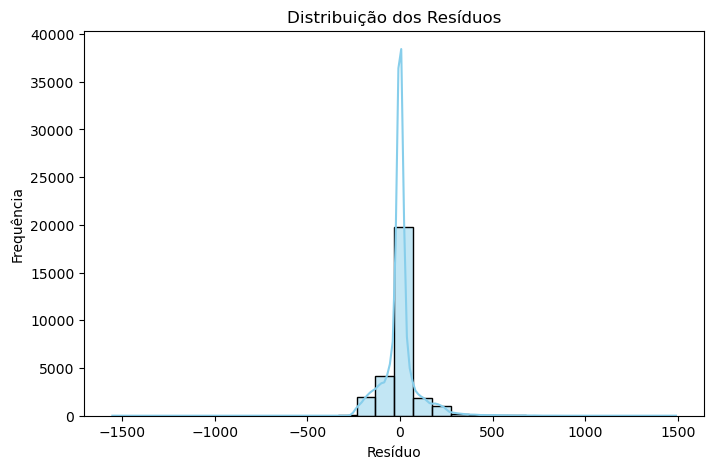

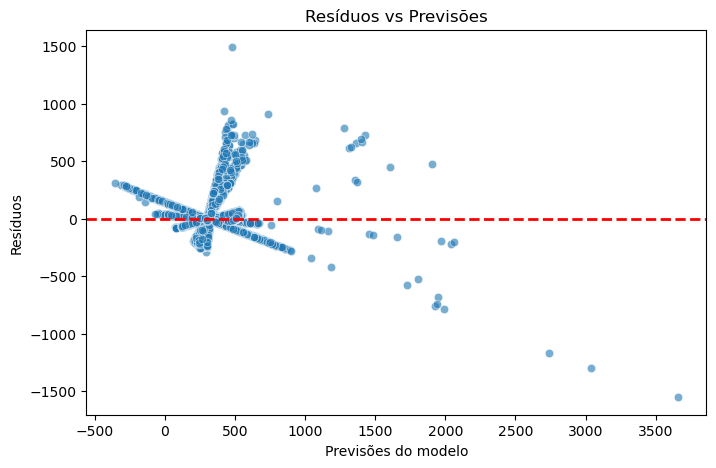

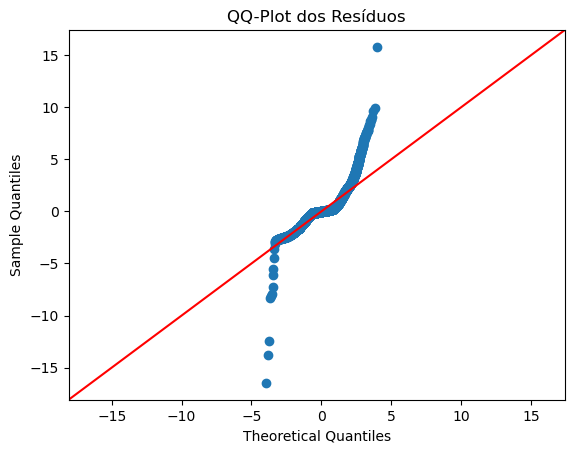

In [31]:
# 1. Selecionar apenas colunas numéricas e garantir float64
X_multi_clean = X_multi.copy()
for col in X_multi_clean.columns:
    X_multi_clean[col] = pd.to_numeric(X_multi_clean[col], errors='coerce')

# 2. Substituir quaisquer NaNs restantes por 0
X_multi_clean = X_multi_clean.fillna(0)

# 3. Garantir tipo float64
X_multi_clean = X_multi_clean.astype(float)

# 4. Adicionar constante
X_multi_sm = sm.add_constant(X_multi_clean)

# 5. Ajustar modelo OLS
modelo_sm = sm.OLS(y.astype(float), X_multi_sm).fit()  # y também precisa ser float
print(modelo_sm.summary())

# 6. Resíduos
residuos = y - modelo_multi.predict(X_multi_clean)

# 7. Distribuição dos resíduos
plt.figure(figsize=(8,5))
sns.histplot(residuos, kde=True, bins=30, color='skyblue')
plt.title("Distribuição dos Resíduos")
plt.xlabel("Resíduo")
plt.ylabel("Frequência")
plt.show()

# 8. Resíduos vs Previsões
plt.figure(figsize=(8,5))
sns.scatterplot(x=modelo_multi.predict(X_multi_clean), y=residuos, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Previsões do modelo")
plt.ylabel("Resíduos")
plt.title("Resíduos vs Previsões")
plt.show()

# 9. QQ-Plot para normalidade dos resíduos
sm.qqplot(residuos, line='45', fit=True)
plt.title("QQ-Plot dos Resíduos")
plt.show()

In [ ]:

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(modelo_multi, X_multi, y, cv=kf, scoring="r2")

print("R² por fold:", scores)
print("Média R²:", scores.mean())

R² por fold: [0.63757926 0.66226231 0.61324098 0.63496366 0.62681621]
Média R²: 0.634972482649656


O modelo pode ser aplicado no **planejamento hospitalar**, ajudando em:

- **Gestão de estoque:** prever consumo de insumos hospitalares mensalmente.
- **Eficiência logística:** reduzir faltas e desperdícios.
- **Suporte à decisão:** embasar políticas de compras e contratos.

### Benefícios
- Antecipação de demanda.
- Otimização de custos.
- Melhor alocação de recursos.

### Limitações
- Modelo assume linearidade.
- Fatores externos (sazonalidade, emergências) não estão modelados.
- Necessidade de atualização com novos dados.
